### 1. 필요 모듈 가져오기

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
from torchvision.datasets import ImageFolder


import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib


### 2. 데이터셋 준비 및 확인 - 클래스명 비율을 고려해서 분할해보기

In [27]:
from sklearn.model_selection import train_test_split

# 랜덤 시드 결정
seed_num =11
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# 폴더에서 데이터 로드
dataset = ImageFolder(root = '../data/resnet_data')
dataset_indices = list(range(len(dataset)))

In [28]:
targets = dataset.targets #폴더별로 라벨링을 해줌

In [29]:
# 80:20 나누기
train_indices,val_test_indices = train_test_split(dataset_indices,test_size=0.2,stratify=targets, random_state=seed_num)
val_test_target = [targets[i] for i in val_test_indices]
# 50:50 나누기
val_indices,test_indices = train_test_split(val_test_indices,test_size=0.5,stratify=val_test_target,random_state=seed_num)

In [30]:
#train_indices, val_indices, test_indices
#최종 데이터셋 생성
# 이거 왜 하는거지?
train_dataset = Subset(dataset,train_indices)
val_dataset =Subset(dataset,val_indices)
test_dataset =Subset(dataset,test_indices)

In [31]:
len(train_dataset),len(val_dataset),len(test_dataset)

(341, 43, 43)

In [32]:
class_idx = dataset.class_to_idx
class_idx

{'마동석': 0, '신세경': 1, '차은우': 2, '카리나': 3}

In [33]:
class_names = {}
for key,val in class_idx.items():
    class_names[val] = key

In [34]:
class_names

{0: '마동석', 1: '신세경', 2: '차은우', 3: '카리나'}

In [35]:
for i in test_dataset:
    print(i)

# 튜플 형태로 저장, 0:이미지 정보 1: 클래스넘버

(<PIL.Image.Image image mode=RGB size=1200x1661 at 0x1ED87561750>, 2)
(<PIL.Image.Image image mode=RGB size=1280x1766 at 0x1ED818F5E70>, 1)
(<PIL.Image.Image image mode=RGB size=447x498 at 0x1ED878B0340>, 2)
(<PIL.Image.Image image mode=RGB size=1200x1623 at 0x1ED8EB93D30>, 2)
(<PIL.Image.Image image mode=RGB size=520x637 at 0x1ED878B0070>, 0)
(<PIL.Image.Image image mode=RGB size=835x556 at 0x1ED87561750>, 3)
(<PIL.Image.Image image mode=RGB size=1143x1714 at 0x1ED878B03A0>, 3)
(<PIL.Image.Image image mode=RGB size=600x900 at 0x1ED818F5E70>, 0)
(<PIL.Image.Image image mode=RGB size=960x1440 at 0x1ED878B0340>, 1)
(<PIL.Image.Image image mode=RGB size=640x960 at 0x1ED87BEDC00>, 0)
(<PIL.Image.Image image mode=RGB size=1200x800 at 0x1ED87561750>, 1)
(<PIL.Image.Image image mode=RGB size=1024x1275 at 0x1ED87BECDC0>, 0)
(<PIL.Image.Image image mode=RGB size=1425x2048 at 0x1ED8EB93D30>, 2)
(<PIL.Image.Image image mode=RGB size=620x907 at 0x1ED87BED780>, 2)
(<PIL.Image.Image image mode=RGB s

ValueError: num must be an integer with 1 <= num <= 21, not 22

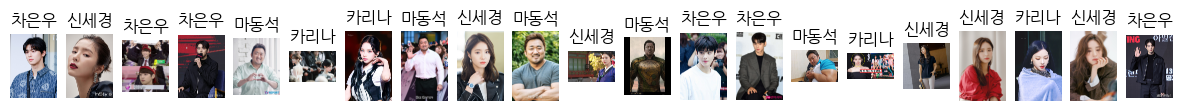

In [36]:
#시각화 해보기
plt.figure(figsize=(15,8))
for idx,item in enumerate(test_dataset,start=1):
    plt.subplot(1,21,idx)
    image = item[0]
    class_name = class_names[item[1]]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
plt.show()

### 3. 이미지 증강 및 전처리 설정 - transforms

In [ ]:
# mean,std 구하는 방법
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std


In [37]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std =[0.229,0.224,0.225])#train_dataset으로 구하기
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std =[0.229,0.224,0.225])
])

In [56]:
#transform 설정
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

#데이터 로더 설정
batch_size = 8
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)

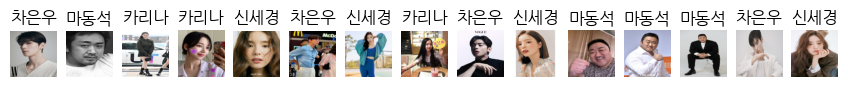

In [57]:
### train dataset 에 transform 적용 확인해보기
plt.figure(figsize=(15,8))

for idx,item in enumerate(train_dataset,start=1):
    if idx ==16:
        break
    plt.subplot(1,21,idx)
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = item[0]
    image = image.cpu().detach().numpy().transpose((1,2,0))
    image = std * image + mean
    image = np.clip(image,0,1)
    
    class_name = class_names[item[1]]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
plt.show()

### 4. 모델 설정

In [58]:
model_ResNet = models.resnet34(weights=None, num_classes=4)


### 5. 손실함수와 옵티마이저 설정

In [59]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

### 6. 학습하기


In [60]:
import torchmetrics
from tqdm.notebook import tqdm


# train 과 val 과정중의 loss값과 accuracy 값을 저장하는것이 목표
def train_and_validate(model, train_loader, val_loader, criterion, epochs, device):
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []
    max_val_acc = 0

    model = model.to(device)
    
    # 옵티마이저 다시 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        # 모델 학습용으로 설정
        model.train()
        running_loss = 0.0

        train_accuracy_metrics = torchmetrics.Accuracy(task="multiclass", num_classes=4, average='macro').to(device)

        # 학습 진행해보기
        for inputs, labels in tqdm(train_loader, desc=f"{epoch} 별 학습 진행중"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 그라디언트 초기화
            optimizer.zero_grad()
            outputs = model(inputs) # 결과
            loss = criterion(outputs, labels)
            loss.backward() # 역전파
            optimizer.step()

            running_loss += loss.item()
            
            # 학습 정확도 계산
            train_accuracy_metrics.update(outputs, labels)
        
        # 에포크별 학습손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # 정확도 계산
        train_accuracy = train_accuracy_metrics.compute().item()
        train_accuracies.append(train_accuracy)

        print(f"에포크별 학습 loss : {epoch_loss:.3f} / 학습 정확도 : {train_accuracy:.2%}")
        
        # 검증 평가
        model.eval()
        running_val_loss = 0.0
        val_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=4, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                # 검증 정확도 업데이트
                val_accuracy_metric.update(outputs, labels)
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)

            # 검증 정확도 계산
            val_accuarcy = val_accuracy_metric.compute().item()

            if max_val_acc < val_accuarcy :
                torch.save(model.state_dict(),"best_Resenet34.pth")
                max_val_acc = val_accuarcy
                print(f"{epoch}_{val_accuarcy} 의 검증 정확도인 베스트 모델 저장")

            val_accuracies.append(val_accuarcy)
            print(f"에포크별 검증 loss : {epoch_val_loss:.3f} / 검증 정확도 : {val_accuarcy:.2%}")

        #val_acc가 가장 높을 때 모델 저장하는 코드 추가하기
    return train_losses, val_losses, train_accuracies, val_accuracies

In [61]:
device = torch.device('cuda')
history = train_and_validate(model_ResNet, train_loader, val_loader, criterion, epochs=100,device=device)

0 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 2.243 / 학습 정확도 : 29.32%
0_0.29423078894615173 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 16.230 / 검증 정확도 : 29.42%


1 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.534 / 학습 정확도 : 32.02%
1_0.32499998807907104 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 14.816 / 검증 정확도 : 32.50%


2 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.556 / 학습 정확도 : 25.20%
에포크별 검증 loss : 4.469 / 검증 정확도 : 32.50%


3 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.434 / 학습 정확도 : 27.54%
에포크별 검증 loss : 2.115 / 검증 정확도 : 28.85%


4 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.398 / 학습 정확도 : 22.66%
4_0.3519230782985687 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.367 / 검증 정확도 : 35.19%


5 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.382 / 학습 정확도 : 27.18%
에포크별 검증 loss : 1.345 / 검증 정확도 : 30.38%


6 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.380 / 학습 정확도 : 27.56%
에포크별 검증 loss : 1.327 / 검증 정확도 : 28.65%


7 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.372 / 학습 정확도 : 29.73%
7_0.3673076927661896 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.283 / 검증 정확도 : 36.73%


8 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.351 / 학습 정확도 : 36.97%
에포크별 검증 loss : 1.333 / 검증 정확도 : 35.38%


9 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.347 / 학습 정확도 : 31.37%
9_0.3730769455432892 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.330 / 검증 정확도 : 37.31%


10 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.320 / 학습 정확도 : 35.09%
에포크별 검증 loss : 1.252 / 검증 정확도 : 34.23%


11 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.364 / 학습 정확도 : 30.01%
에포크별 검증 loss : 1.384 / 검증 정확도 : 28.65%


12 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.374 / 학습 정확도 : 27.39%
에포크별 검증 loss : 1.304 / 검증 정확도 : 28.46%


13 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.339 / 학습 정확도 : 30.67%
13_0.4038461744785309 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.285 / 검증 정확도 : 40.38%


14 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.353 / 학습 정확도 : 33.12%
에포크별 검증 loss : 1.296 / 검증 정확도 : 39.04%


15 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.308 / 학습 정확도 : 40.75%
에포크별 검증 loss : 1.221 / 검증 정확도 : 39.62%


16 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.293 / 학습 정확도 : 38.64%
16_0.45961540937423706 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.380 / 검증 정확도 : 45.96%


17 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.298 / 학습 정확도 : 39.23%
에포크별 검증 loss : 1.388 / 검증 정확도 : 41.35%


18 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.310 / 학습 정확도 : 37.85%
에포크별 검증 loss : 1.253 / 검증 정확도 : 43.46%


19 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.292 / 학습 정확도 : 39.82%
에포크별 검증 loss : 1.328 / 검증 정확도 : 35.19%


20 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.279 / 학습 정확도 : 42.35%
에포크별 검증 loss : 1.433 / 검증 정확도 : 31.35%


21 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.260 / 학습 정확도 : 43.41%
에포크별 검증 loss : 1.308 / 검증 정확도 : 43.46%


22 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.247 / 학습 정확도 : 41.34%
22_0.47884613275527954 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.245 / 검증 정확도 : 47.88%


23 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.240 / 학습 정확도 : 43.66%
에포크별 검증 loss : 1.767 / 검증 정확도 : 37.69%


24 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.238 / 학습 정확도 : 44.87%
에포크별 검증 loss : 1.249 / 검증 정확도 : 43.46%


25 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.236 / 학습 정확도 : 46.36%
에포크별 검증 loss : 1.527 / 검증 정확도 : 39.81%


26 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.186 / 학습 정확도 : 49.45%
에포크별 검증 loss : 1.307 / 검증 정확도 : 41.54%


27 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.224 / 학습 정확도 : 47.47%
에포크별 검증 loss : 1.279 / 검증 정확도 : 42.12%


28 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.161 / 학습 정확도 : 49.69%
28_0.5538461804389954 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.229 / 검증 정확도 : 55.38%


29 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.182 / 학습 정확도 : 47.83%
에포크별 검증 loss : 1.405 / 검증 정확도 : 39.62%


30 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.154 / 학습 정확도 : 48.55%
에포크별 검증 loss : 1.202 / 검증 정확도 : 42.88%


31 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.135 / 학습 정확도 : 51.57%
에포크별 검증 loss : 1.288 / 검증 정확도 : 49.81%


32 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.078 / 학습 정확도 : 53.95%
에포크별 검증 loss : 1.298 / 검증 정확도 : 49.81%


33 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.134 / 학습 정확도 : 51.00%
에포크별 검증 loss : 1.440 / 검증 정확도 : 41.54%


34 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.070 / 학습 정확도 : 53.57%
에포크별 검증 loss : 1.321 / 검증 정확도 : 43.46%


35 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.109 / 학습 정확도 : 52.91%
에포크별 검증 loss : 1.359 / 검증 정확도 : 37.12%


36 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.106 / 학습 정확도 : 50.29%
에포크별 검증 loss : 1.200 / 검증 정확도 : 43.46%


37 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.124 / 학습 정확도 : 47.72%
에포크별 검증 loss : 1.557 / 검증 정확도 : 40.38%


38 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.050 / 학습 정확도 : 55.31%
에포크별 검증 loss : 1.250 / 검증 정확도 : 47.69%


39 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.951 / 학습 정확도 : 64.74%
에포크별 검증 loss : 1.230 / 검증 정확도 : 44.04%


40 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 1.010 / 학습 정확도 : 56.85%
에포크별 검증 loss : 1.260 / 검증 정확도 : 42.12%


41 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.931 / 학습 정확도 : 61.09%
에포크별 검증 loss : 1.216 / 검증 정확도 : 40.38%


42 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.940 / 학습 정확도 : 65.82%
에포크별 검증 loss : 1.396 / 검증 정확도 : 45.38%


43 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.930 / 학습 정확도 : 63.26%
에포크별 검증 loss : 1.416 / 검증 정확도 : 49.81%


44 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.902 / 학습 정확도 : 62.73%
에포크별 검증 loss : 1.474 / 검증 정확도 : 49.62%


45 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.919 / 학습 정확도 : 65.63%
에포크별 검증 loss : 1.536 / 검증 정확도 : 38.85%


46 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.825 / 학습 정확도 : 64.68%
에포크별 검증 loss : 1.257 / 검증 정확도 : 54.62%


47 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.677 / 학습 정확도 : 74.16%
47_0.5653846263885498 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 0.995 / 검증 정확도 : 56.54%


48 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.774 / 학습 정확도 : 69.56%
에포크별 검증 loss : 1.316 / 검증 정확도 : 50.96%


49 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.689 / 학습 정확도 : 73.25%
49_0.5923076868057251 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.018 / 검증 정확도 : 59.23%


50 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.735 / 학습 정확도 : 71.17%
에포크별 검증 loss : 1.365 / 검증 정확도 : 51.54%


51 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.675 / 학습 정확도 : 70.50%
에포크별 검증 loss : 1.143 / 검증 정확도 : 57.12%


52 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.526 / 학습 정확도 : 81.59%
52_0.6326923370361328 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 1.377 / 검증 정확도 : 63.27%


53 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.519 / 학습 정확도 : 78.66%
에포크별 검증 loss : 1.134 / 검증 정확도 : 60.96%


54 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.490 / 학습 정확도 : 82.74%
에포크별 검증 loss : 1.419 / 검증 정확도 : 61.54%


55 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.461 / 학습 정확도 : 83.40%
에포크별 검증 loss : 1.345 / 검증 정확도 : 60.19%


56 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.516 / 학습 정확도 : 80.11%
56_0.7288461923599243 의 검증 정확도인 베스트 모델 저장
에포크별 검증 loss : 0.918 / 검증 정확도 : 72.88%


57 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.379 / 학습 정확도 : 85.91%
에포크별 검증 loss : 1.173 / 검증 정확도 : 56.54%


58 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.364 / 학습 정확도 : 87.92%
에포크별 검증 loss : 1.543 / 검증 정확도 : 54.04%


59 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.267 / 학습 정확도 : 90.19%
에포크별 검증 loss : 0.974 / 검증 정확도 : 64.81%


60 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.164 / 학습 정확도 : 95.26%
에포크별 검증 loss : 1.131 / 검증 정확도 : 66.54%


61 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.323 / 학습 정확도 : 87.66%
에포크별 검증 loss : 2.072 / 검증 정확도 : 54.81%


62 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.334 / 학습 정확도 : 89.46%
에포크별 검증 loss : 1.089 / 검증 정확도 : 66.73%


63 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.315 / 학습 정확도 : 87.60%
에포크별 검증 loss : 1.537 / 검증 정확도 : 67.12%


64 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.140 / 학습 정확도 : 95.46%
에포크별 검증 loss : 1.440 / 검증 정확도 : 66.54%


65 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.114 / 학습 정확도 : 96.45%
에포크별 검증 loss : 1.296 / 검증 정확도 : 59.04%


66 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.077 / 학습 정확도 : 97.88%
에포크별 검증 loss : 1.276 / 검증 정확도 : 68.46%


67 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.156 / 학습 정확도 : 94.37%
에포크별 검증 loss : 1.554 / 검증 정확도 : 62.88%


68 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.175 / 학습 정확도 : 94.51%
에포크별 검증 loss : 1.457 / 검증 정확도 : 59.81%


69 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.193 / 학습 정확도 : 92.32%
에포크별 검증 loss : 1.978 / 검증 정확도 : 45.77%


70 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.149 / 학습 정확도 : 95.02%
에포크별 검증 loss : 1.237 / 검증 정확도 : 59.81%


71 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.110 / 학습 정확도 : 96.68%
에포크별 검증 loss : 1.280 / 검증 정확도 : 67.31%


72 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.051 / 학습 정확도 : 98.26%
에포크별 검증 loss : 1.091 / 검증 정확도 : 60.96%


73 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.019 / 학습 정확도 : 99.69%
에포크별 검증 loss : 1.658 / 검증 정확도 : 70.96%


74 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.034 / 학습 정확도 : 99.06%
에포크별 검증 loss : 2.343 / 검증 정확도 : 61.54%


75 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.043 / 학습 정확도 : 98.82%
에포크별 검증 loss : 1.963 / 검증 정확도 : 57.31%


76 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.045 / 학습 정확도 : 98.75%
에포크별 검증 loss : 2.080 / 검증 정확도 : 65.96%


77 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.162 / 학습 정확도 : 95.19%
에포크별 검증 loss : 2.337 / 검증 정확도 : 58.27%


78 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.153 / 학습 정확도 : 94.32%
에포크별 검증 loss : 1.428 / 검증 정확도 : 57.31%


79 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.116 / 학습 정확도 : 95.96%
에포크별 검증 loss : 1.650 / 검증 정확도 : 54.04%


80 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.152 / 학습 정확도 : 94.64%
에포크별 검증 loss : 1.941 / 검증 정확도 : 64.04%


81 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.115 / 학습 정확도 : 95.89%
에포크별 검증 loss : 1.365 / 검증 정확도 : 60.38%


82 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.048 / 학습 정확도 : 98.57%
에포크별 검증 loss : 1.674 / 검증 정확도 : 54.62%


83 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.093 / 학습 정확도 : 97.69%
에포크별 검증 loss : 1.710 / 검증 정확도 : 54.62%


84 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.066 / 학습 정확도 : 99.13%
에포크별 검증 loss : 1.098 / 검증 정확도 : 61.54%


85 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.023 / 학습 정확도 : 99.75%
에포크별 검증 loss : 1.233 / 검증 정확도 : 55.38%


86 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.006 / 학습 정확도 : 100.00%
에포크별 검증 loss : 1.404 / 검증 정확도 : 63.46%


87 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.014 / 학습 정확도 : 99.44%
에포크별 검증 loss : 1.295 / 검증 정확도 : 71.54%


88 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.032 / 학습 정확도 : 98.81%
에포크별 검증 loss : 1.449 / 검증 정확도 : 54.62%


89 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.043 / 학습 정확도 : 99.13%
에포크별 검증 loss : 1.393 / 검증 정확도 : 63.46%


90 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.036 / 학습 정확도 : 98.43%
에포크별 검증 loss : 1.426 / 검증 정확도 : 67.88%


91 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.107 / 학습 정확도 : 97.00%
에포크별 검증 loss : 2.470 / 검증 정확도 : 56.54%


92 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.070 / 학습 정확도 : 98.19%
에포크별 검증 loss : 2.029 / 검증 정확도 : 53.46%


93 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.085 / 학습 정확도 : 97.56%
에포크별 검증 loss : 2.108 / 검증 정확도 : 57.88%


94 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.219 / 학습 정확도 : 93.57%
에포크별 검증 loss : 1.890 / 검증 정확도 : 43.46%


95 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.097 / 학습 정확도 : 96.12%
에포크별 검증 loss : 1.663 / 검증 정확도 : 53.46%


96 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.048 / 학습 정확도 : 98.50%
에포크별 검증 loss : 1.913 / 검증 정확도 : 58.46%


97 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.042 / 학습 정확도 : 98.57%
에포크별 검증 loss : 1.684 / 검증 정확도 : 64.81%


98 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.008 / 학습 정확도 : 100.00%
에포크별 검증 loss : 1.710 / 검증 정확도 : 61.54%


99 별 학습 진행중:   0%|          | 0/43 [00:00<?, ?it/s]

에포크별 학습 loss : 0.008 / 학습 정확도 : 99.75%
에포크별 검증 loss : 1.682 / 검증 정확도 : 60.96%


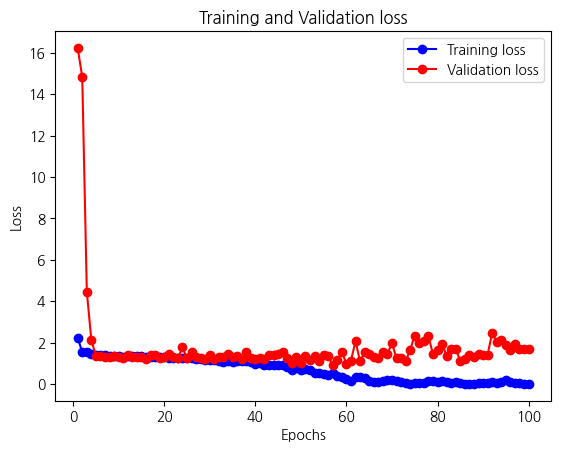

In [62]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
train_losses, val_losses = history[:2]

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

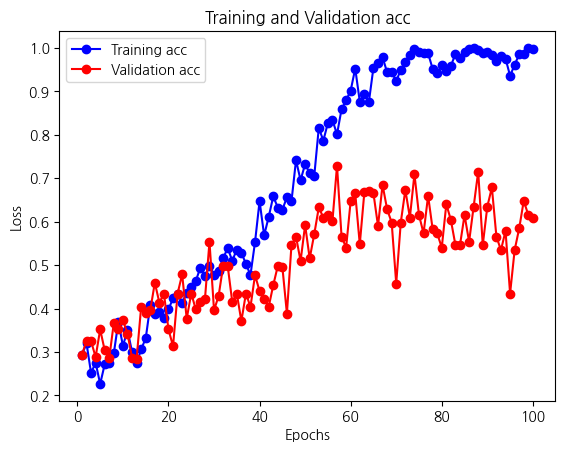

In [63]:
# train_and_validate 함수로부터 손실 기록 받기
train_accies, val_accies = history[2:]

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_accies, 'bo-', label='Training acc')
plt.plot(epochs, val_accies, 'ro-', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [64]:
def evaluate(model, loader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)
    with torch.no_grad():
        for data in tqdm(loader, desc=f"최종평가중"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()


In [65]:
evaluate(model_ResNet, test_loader, device)

최종평가중:   0%|          | 0/6 [00:00<?, ?it/s]

테스트 이미지 정확도 계산: 64.81%


0.6480768918991089


1.  batch_size = 8 : 테스트 이미지 정확도 계산: 64.81%

In [ ]:

#꺠진 파일 찾기
import os
from PIL import Image

#전체 경로를 사용하여 경로 설정
checkdir = r'C:\project\python_basic\6_딥러닝\data\resnet_data\카리나'  # Windows의 경우 전체 경로 사용

formats = [".jpg", ".jpeg", ".png", ".webp"]

if not os.path.exists(checkdir):
    print(f"The directory {checkdir} does not exist.")
else:
    for root, dirs, files in os.walk(checkdir):
        for file in files:
            if file.lower().endswith(tuple(formats)):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.load()
                except Exception as e:
                    print(f"An exception is raised with file: {file_path} - {e}")
